In [29]:
from load_data import parameters_dict, simulation_file_paths

import numpy as np
# import saved feature array
feature_arr = np.load("feature_arr.npy")

In [61]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples


def silhouette_score_mod(feature_arr, labels):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    sample_silhouette_values = silhouette_samples(feature_arr, labels)
    score_mod = 0
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        max_silhouette = np.max(ith_cluster_silhouette_values)
        if max_silhouette > silhouette_score(feature_arr, labels):
            score_mod += 1
        
    return score_mod/float(n_clusters)

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Compute DBSCAN
db = DBSCAN(eps=0.64, min_samples=10).fit(feature_arr)
silhouette_score_ = silhouette_score(feature_arr, db.labels_)
print(silhouette_score_)
print(silhouette_score_mod(feature_arr, db.labels_))

    

0.41656822
1.0


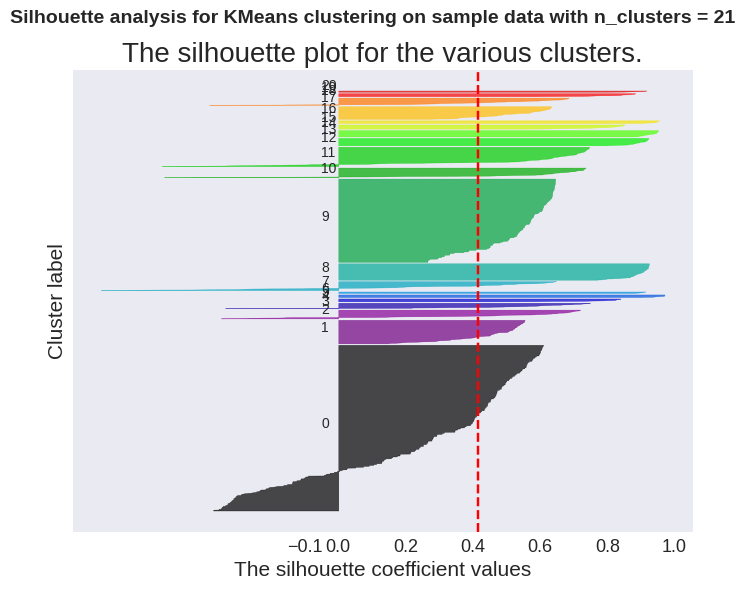

In [59]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

n_clusters = len(set(db.labels_))
cluster_labels = db.labels_

# The silhouette_score gives the average value for all the samples.
silhouette_avg = silhouette_score(feature_arr, cluster_labels)
sample_silhouette_values = silhouette_samples(feature_arr, cluster_labels)

y_lower = 10
for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

   

plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [62]:
# hyperparameter optimization
import optuna


def objective(trial):
    eps = trial.suggest_float("eps", 0.5, 1.5)
    min_samples = trial.suggest_int("min_samples", 2, 10)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(feature_arr)
    score = silhouette_score(feature_arr, labels)
    score_mod = silhouette_score_mod(feature_arr, labels)
    return [score, score_mod]


# search_space = {"eps": (0.5, 1.5), "min_samples": (2, 10)}
study = optuna.create_study(directions=["maximize", "maximize"], study_name="DBSCAN_ssmod",
                            storage="sqlite:///test.db", load_if_exists=True)
study.optimize(objective, n_trials=100)



[I 2024-03-27 11:42:43,727] Using an existing study with name 'DBSCAN_ssmod' instead of creating a new one.


[I 2024-03-27 11:42:46,312] Trial 305 finished with values: [0.2564407289028168, 1.0] and parameters: {'eps': 0.9112682614799205, 'min_samples': 6}. 
[I 2024-03-27 11:42:48,210] Trial 306 finished with values: [0.28699496388435364, 1.0] and parameters: {'eps': 1.1093406295752317, 'min_samples': 6}. 
[I 2024-03-27 11:42:50,612] Trial 307 finished with values: [0.16907799243927002, 1.0] and parameters: {'eps': 0.7327001273941725, 'min_samples': 4}. 
[I 2024-03-27 11:42:52,685] Trial 308 finished with values: [0.287891149520874, 1.0] and parameters: {'eps': 1.3202476140324029, 'min_samples': 5}. 
[I 2024-03-27 11:42:54,500] Trial 309 finished with values: [0.21637028455734253, 1.0] and parameters: {'eps': 0.8506387695390628, 'min_samples': 9}. 
[I 2024-03-27 11:42:57,553] Trial 310 finished with values: [0.5226531624794006, 1.0] and parameters: {'eps': 0.5004144255984934, 'min_samples': 4}. 
[I 2024-03-27 11:42:59,118] Trial 311 finished with values: [0.28090333938598633, 1.0] and paramet

In [34]:
for i in study.best_trials:
    print(i.params)
    print(i.values)

{'eps': 0.5605631981335262, 'min_samples': 4}
[0.5284974575042725, 0.0]


In [64]:
study1 = study.best_trials[0]
dbscan = DBSCAN(eps=study1.params["eps"], min_samples=study1.params["min_samples"])
labels = dbscan.fit_predict(feature_arr)
silhouette_score_ = silhouette_score(feature_arr, labels)
print(silhouette_score_)
silhouette_score_mod(feature_arr, labels)
print(silhouette_score_mod(feature_arr, labels))

# plot
n_clusters = len(set(labels))
cluster_labels = labels

import plotly.graph_objs as go
import plotly.express as ptx

class_dict = {f"Class {i}": list() for i in range(len(set(dbscan.labels_)))}
class_dict["Outliers"] = list()
for index, path in enumerate(simulation_file_paths):
    class_ = dbscan.labels_[index]
    if class_ == -1:
        class_dict["Outliers"].append(str(path))
    else:
        class_dict[f"Class {class_}"].append(str(path))

traces = list()
for class_id, colour in zip(class_dict, ptx.colors.qualitative.Dark24):
    traces.append(
        go.Scatter(
            x=[
                parameters_dict[f]["H"]
                for f in class_dict[class_id]
            ],
            y=[
                parameters_dict[f]["E"]
                for f in class_dict[class_id]
            ],
            mode="markers",
            name=class_id,
            opacity=0.7,
            marker=dict(
                size=11,
                color=colour,
            ),
        )
    )

fig = go.Figure(data=traces)
fig.update_layout(
    autosize=False,
    width=990,
    height=600,
    margin=dict(
        l=10,
        r=10,
        b=25,
        t=25,
    ),
    xaxis_title=r"$\mu_0 \mathbf{H} \text{ (T)}$",
    yaxis_title=r"$\Delta \text{E (J)}$",
)

0.52849746
1.0


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#2E91E5', 'size': 11},
              'mode': 'markers',
              'name': 'Class 0',
              'opacity': 0.7,
              'type': 'scatter',
              'x': [0.6698909203044445, 0.6698909203044445, 0.6698909203044445,
                    ..., 0.6546227281234838, 0.6546227281234838,
                    0.6546227281234838],
              'y': [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]},
             {'marker': {'color': '#E15F99', 'size': 11},
              'mode': 'markers',
              'name': 'Class 1',
              'opacity': 0.7,
              'type': 'scatter',
              'x': [0.6698909203044445, 0.7108584663581602, 1.0250054051919253,
                    1.0250054051919253, 1.0520917899467686, 0.9646048372886914,
                    0.9646048372886914, 0.9207083700108073, 0.9207083700108073,
                    0.7015080933424875, 1.1929253724128137, 0.746403496136002,
                    1.0976181620612193, 1.1469998419153746, 0.9808002518152286,
                    0.9808002518152286, 0.6597066901473676, 0.9291651296158059,
                    0.9291651296158059, 0.7125494922138771, 0.9249011197760583,
                    0.9249011197760583, 0.836415867916509, 0.720271961003612,
                    1.1141259767768092, 1.1071872073552032, 1.1086917079049514,
                    1.1955561140906563, 0.8202076505365383, 0.8202076505365383,
                    0.9864011704620863, 0.9864011704620863, 0.7453627241490277,
                    1.1305127224462546, 0.657065121899311, 0.8197104804685906,
                    0.8197104804685906, 1.0847157664043714, 0.7867600810417402,
                    1.0202856143980115, 1.0202856143980115, 0.8028197934355251,
                    0.8028197934355251, 1.1954039370060294, 0.8347188180131706,
                    1.0138643716232256, 1.0138643716232256, 0.8362432922424539,
                    0.9066727290485987, 0.9066727290485987, 0.7520385821733719,
                    0.8775627476181801, 0.8775627476181801, 1.1735348343250152,
                    0.8115632219784964, 0.8115632219784964, 0.7038115819871134,
                    1.1827621140750701, 0.9130732008672463, 0.9130732008672463,
                    0.6699039315395161, 1.1661932580993006, 0.6873601795375328,
                    0.6570880888695172, 1.1090159870748109, 0.790605703246432,
                    0.9269515687798381, 0.9269515687798381, 0.9698279207025753,
                    0.9698279207025753, 1.1770707825786892, 1.116615272717344,
                    1.0718182521919446, 0.8843678484873443, 0.8843678484873443,
                    0.9641370033042524, 0.9641370033042524, 1.0505179873860966,
                    0.8027673907963068, 0.8027673907963068, 1.1402152872098037,
                    0.6848079906719802, 0.7474323434833914, 0.8237846523064629,
                    0.9581704014515433, 0.9581704014515433, 1.0706344716555656,
                    0.7897525671244984, 0.9935376695424457, 0.9935376695424457,
                    0.8850705377887228, 0.8850705377887228, 0.9742161584909454,
                    0.9742161584909454, 0.6997767539785071, 0.7983981074624066,
                    1.173866898580667, 0.6742951967549535, 0.8204690678947646,
                    0.8204690678947646, 1.0934684341269973, 1.0515676079188805,
                    0.7179679094332169, 0.9898962581019028, 0.9898962581019028,
                    1.112307266850654, 1.140888569640036, 1.0282460428447024,
                    1.0282460428447024, 0.9981815390658192, 0.9981815390658192,
                    0.8637599795213791, 0.8637599795213791, 0.9448716255746837,
                    0.9448716255746837, 0.9953320671441747, 0.9953320671441747,
                    0.9951803409357836, 0.9951803409357836, 1.1603903092753214,
                    0.9861663886355949, 0.9861663886355949, 1.1120120774019429,
                    1.1122117803842337, 1.0465188935411227, 1.016188363672831,
                    1.01